### Loading the COCO dataset and COCO API code

In [ ]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2021-01-02 13:03:39--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.184.131
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.184.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  56.8MB/s    in 5m 6s   

2021-01-02 13:08:46 (60.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-01-02 13:08:46--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.76.100
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.76.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  51.3MB/s    in 13s     

2021-01-02 13:09:00 (60.3 MB/s) - 

### Importing libraries

In [ ]:
import os
import skimage.io as io
import numpy as np

### Importing TensorFlow

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow 1.x selected.
TensorFlow version: 1.15.2


### Importing the COCO API library

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Creating a Dataset class
This class constructs `tf.data.Dataset` samples and is universal for segmentation with different datasets.

However, it is an abstract class where the method of reading in the dataset from disc is not implemented as that procedure could be different for various datasets.

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### COCO_Dataset class
This class will be inherited from the `Dataset` class and contain the unique implementation of the `read_images` method for the COCO dataset.

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Creating a training and validation dataset

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=17.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [ ]:
train_ds = COCO_dataset_train.train_dataset(epochs=5, inp_size=256, batch_size=2)
val_ds = COCO_dataset_val.val_dataset(inp_size=256, batch_size=2)

# Setting up the model training pipeline

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')        
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')        
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')    
        
        self.conv7 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')        
        self.conv9 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv11 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')
        
        self.pool = tf.keras.layers.MaxPool2D((2, 2))
        self.unpool = tf.keras.layers.UpSampling2D((2, 2))
                
    def call(self, x):
      
        # Encoder
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool(out)        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool(out)        
        out = self.conv5(out)
        out = self.conv6(out)
        
        # Decoder        
        out = self.unpool(out)        
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.unpool(out)        
        out = self.conv9(out)
        out = self.conv10(out)
        out = self.conv11(out)

        return out
    
model = Model()

Let us compile the model and initiate the training process:

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
for i in range(4):
  hist = model.fit(train_ds,epochs=5, steps_per_epoch=40)

Train for 40 steps
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
40/40 [==============================] - 256s 6s/step - loss: 0.5663 - acc: 0.7875
Epoch 2/5
40/40 [==============================] - 255s 6s/step - loss: 0.5741 - acc: 0.7865
Epoch 3/5
40/40 [==============================] - 256s 6s/step - loss: 0.4709 - acc: 0.8319
Epoch 4/5
40/40 [==============================] - 255s 6s/step - loss: 0.5680 - acc: 0.7398
Epoch 5/5
40/40 [==============================] - 256s 6s/step - loss: 0.5319 - acc: 0.7862
Train for 40 steps
Epoch 1/5
40/40 [==============================] - 254s 6s/step - loss: 0.5182 - acc: 0.7927
Epoch 2/5
40/40 [==============================] - 254s 6s/step - loss: 0.4627 - acc: 0.7963
Epoch 3/5
40/40 [==============================] - 254s 6s/step - loss: 0.4712 - acc: 0.8320
Epoch 4/5
40/40 [==============================] - 255s 6s/step - loss: 0.5424 - acc: 0.7747
Epoch 5/5
40/40 [==============

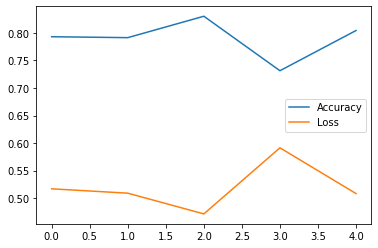

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["acc"], label="Accuracy")
plt.plot(hist.history["loss"], label="Loss")
plt.legend(loc="best")
plt.show()

In [ ]:
def pred(img):

  out = model.predict(tf.keras.preprocessing.image.img_to_array(img)[None, ...])

  plt.imshow(tf.keras.preprocessing.image.array_to_img(out[0,...]))

  plt.show()

img = tf.keras.preprocessing.image.load_img(COCO_ROOT+"val2017//000000000285.jpg",target_size=(256, 256))

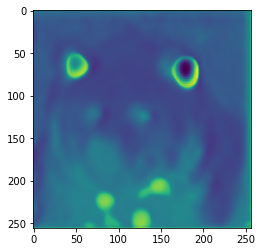

In [ ]:
pred(img)
# training took a long time, so a small number of epochs was set
# we see from the visualization that the training proceeds in the right
# direction, so if we train the model further, we will get more accurate results